# Assignment 4: Feature points, matching, homography

### Exercise 1: Feature points detectors

#### (a) Hessian detector

Q: What kind of structures are detected by the algorithm? How does the parameter sigma affect the result? \
A: Corners. Changes the size of corners detected.

In [148]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [149]:
def normalize(xs):
    res = [abs(x) for x in xs]
    return xs / np.sum(res)
    
def gaussdx(sigma):
    return np.array(normalize([(-1/(np.sqrt(2 * np.pi) * sigma**3)) * x * np.exp(-x**2 / (2 * sigma**2)) for x in np.arange(-np.ceil(3*sigma), np.ceil(3*sigma)+1, 1)]))

In [150]:
def gaussian_kernel(sigma):
    return np.array([1 / (np.sqrt(2*np.pi) * sigma) * np.exp((-np.square(x)) / (2 * np.square(sigma))) for x in np.arange(-np.ceil(3*sigma), np.ceil(3*sigma)+1, 1)])

In [151]:
def derive_1(img, sigma):
    img = img.astype(np.float64)

    gx = gaussian_kernel(sigma)
    gy = np.reshape(gx, (1, -1))
    
    d_gx = gaussdx(sigma)
    d_gy = np.reshape(d_gx, (1, -1))
    
    # switch x and y because filter2D will use (256, ) shape as (1, 256)
    gx, gy, d_gx, d_gy = gy, gx, d_gy, d_gx
    
    dx_img = cv2.filter2D(cv2.filter2D(img, -1, gy), -1, d_gx)
    dy_img = cv2.filter2D(cv2.filter2D(img, -1, gx), -1, d_gy)
    
    return dx_img, dy_img

def derive_2(img, sigma):
    #img = img.astype(np.float64)
    gx = gaussian_kernel(sigma)
    gy = np.reshape(gx, (1, -1))
    
    d_gx = gaussdx(sigma)
    d_gy = np.reshape(d_gx, (1, -1))
    
    dx_img, dy_img = derive_1(img, sigma)
    
    dx_img = cv2.filter2D(dx_img, -1, gx)
    dy_img = cv2.filter2D(dy_img, -1, gy)
    
    # switch x and y because filter2D will use (256, ) shape as (1, 256)
    dxx_img = cv2.filter2D(cv2.filter2D(dx_img, -1, gx), -1, d_gy)
    dxy_img = cv2.filter2D(cv2.filter2D(dx_img, -1, gy), -1, d_gx)
    dyy_img = cv2.filter2D(cv2.filter2D(dy_img, -1, gx), -1, d_gy)
    
    return dxx_img, dxy_img, dyy_img


In [152]:
def nonmaxima_suppression(img, boxsize, thresh=0.004):
    for i in range(1,img.shape[0]-boxsize):
        for j in range(1,img.shape[1]-boxsize):                
            neighborhood = [img[i-boxsize,j-boxsize], img[i-boxsize,j], img[i-boxsize, j+boxsize],
                    img[i,j-boxsize], img[i,j+boxsize], 
                    img[i+boxsize,j-boxsize], img[i+boxsize,j], img[i+boxsize,j+boxsize]]
            
            # Check if its the strongest
            if np.max(neighborhood) > img[i,j]:
                # Remove multiple maximums
                if np.max(neighborhood) == img[i,j]:
                    np.where(neighborhood == img[i,j], 0, img[i,j])
                
                img[i,j] = 0
    return img
            

In [153]:
def hessian_points(img, thresh, sigma=3):
    '''
        Takes in grayscale image, return Hessian determinant
    '''
    Ixx, Ixy, Iyy = derive_2(img, sigma)
    
    det = Ixx * Iyy - np.square(Ixy)
    det[det < thresh] = 0
    #det = nonmaxima_suppression(det, 10)
    return det   

In [154]:
def plot_points(img, thresh):
    '''
        Takes in image determinant and plots all points on the original image
    '''
    xs = []
    ys = []
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
           if img[y, x] > thresh:
               xs.append(x)
               ys.append(y)
    return xs, ys 

In [155]:
img_test_orig = cv2.imread("data/graf/graf_a.jpg")
img_test_orig = cv2.cvtColor(img_test_orig, cv2.COLOR_BGR2GRAY)

n_neighbors = 9

# Sigma = 3
det_test_3 = hessian_points(img_test_orig, 70, 3)
det_test_3 = nonmaxima_suppression(det_test_3, n_neighbors)

# Sigma = 6
det_test_6 = hessian_points(img_test_orig, 70, 6)
det_test_6 = nonmaxima_suppression(det_test_6, n_neighbors)

# Sigma = 9
det_test_9 = hessian_points(img_test_orig, 70, 9)
det_test_9 = nonmaxima_suppression(det_test_9, n_neighbors)

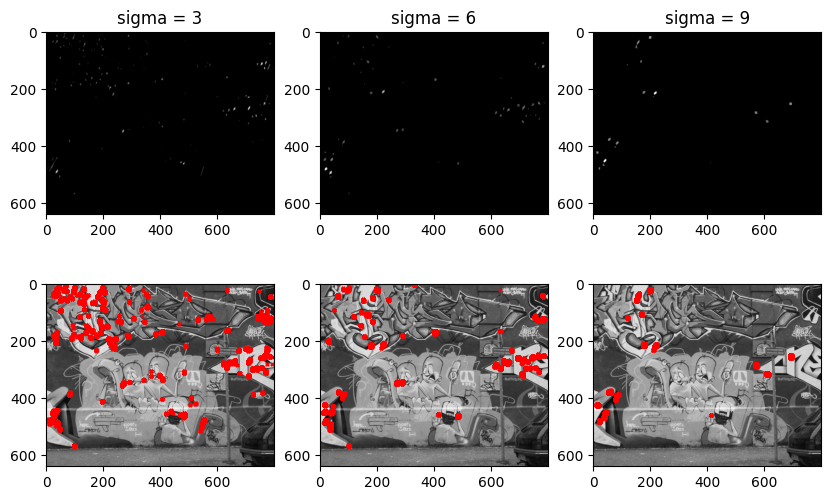

In [156]:
fig, ax = plt.subplots(2,3,figsize=(10,6))

xs3, ys3 = plot_points(det_test_3, 60)
ax[0,0].imshow(det_test_3, cmap="gray")
ax[0,0].set_title("sigma = 3")

ax[1,0].scatter(xs3, ys3, marker="x", c="red", s=5)
ax[1,0].imshow(img_test_orig, cmap="gray")

xs6, ys6 = plot_points(det_test_6, 60)
ax[0,1].imshow(det_test_6, cmap="gray")
ax[0,1].set_title("sigma = 6")

ax[1,1].scatter(xs6, ys6, marker="x", c="red", s=5)
ax[1,1].imshow(img_test_orig, cmap="gray")

xs9, ys9 = plot_points(det_test_9, 60)
ax[0,2].imshow(det_test_9, cmap="gray" )
ax[0,2].set_title("sigma = 9")

ax[1,2].scatter(xs9, ys9, marker="x", c="red", s=5)
ax[1,2].imshow(img_test_orig, cmap="gray")

#### (b) Harris detector

In [157]:
smoothing_sigma_factor = 1.6

In [158]:
def C_mat(img, sigma):
    
    Ix, Iy = derive_1(img, sigma * smoothing_sigma_factor)
        
    # smoothe img with gauss
    kernel = gaussian_kernel(sigma * smoothing_sigma_factor)
    kernel_T = np.reshape(kernel, (1, -1))
    img = cv2.filter2D(img, -1, kernel)
    
    # Get values
    sxx = cv2.filter2D(cv2.filter2D(np.square(Ix), -1, kernel), -1, kernel_T)
    sxy = cv2.filter2D(cv2.filter2D((Ix * Iy), -1, kernel), -1, kernel_T);
    syy = cv2.filter2D(cv2.filter2D(np.square(Iy), -1, kernel.T), -1, kernel_T)
    
    
    return np.array([[sxx, sxy], [sxy, syy]]) 

In [176]:
def check_corner(img_orig, C, thresh):
    img = img_orig.copy()
    alpha = 0.06
    
    det = (C[0,0] * C[1,1]) - np.square(C[1,0])
    trace = C[0,0] + C[1,1]
    
    img[det - alpha * np.square(trace) < thresh] = 0        

    return det - alpha * np.square(trace) #img

In [213]:
C3 = C_mat(img_test_orig, 3)

n_neighbors = 6
thresh = 1e-5

corner_map3 = check_corner(img_test_orig, C3, thresh)
corner_map3 = nonmaxima_suppression(corner_map3, n_neighbors)
corner_map3 /= np.max(corner_map3)

C6 = C_mat(img_test_orig, 6)
corner_map6 = check_corner(img_test_orig, C6, thresh)
corner_map6 = nonmaxima_suppression(corner_map6, n_neighbors)
corner_map6 /= np.max(corner_map6)

C9 = C_mat(img_test_orig, 9)
corner_map9 = check_corner(img_test_orig, C9, thresh)
corner_map9 = nonmaxima_suppression(corner_map9, n_neighbors)
corner_map9 /= np.max(corner_map9)

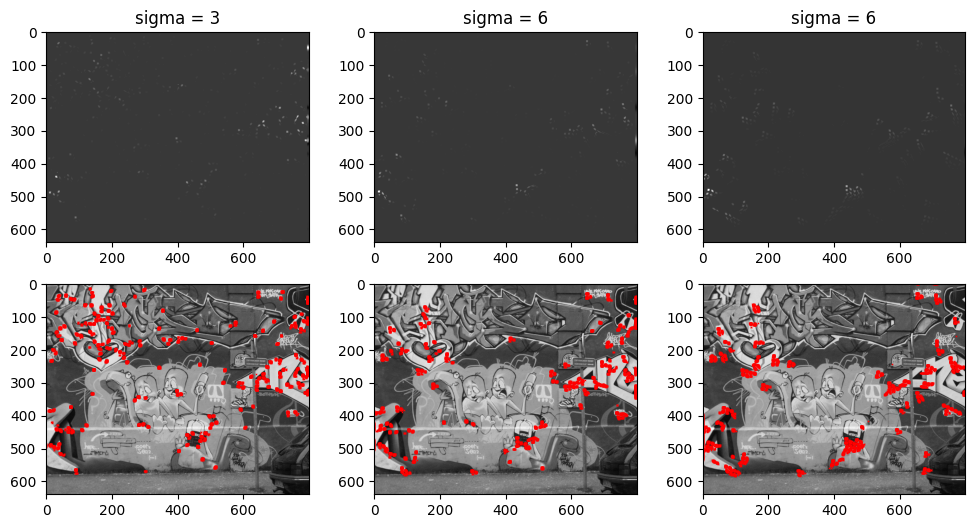

In [215]:
thresh = .03

fig, ax = plt.subplots(2, 3, figsize=(12,6))

xs3, ys3 = plot_points(corner_map3, thresh)
ax[0,0].imshow(corner_map3, cmap="gray")
ax[0,0].set_title("sigma = 3")

ax[1,0].scatter(xs3, ys3, marker="x", c="r", s=.1)
ax[1,0].imshow(img_test_orig, cmap="gray")


xs6, ys6 = plot_points(corner_map6, thresh)
ax[0,1].imshow(corner_map6, cmap="gray")
ax[0,1].set_title("sigma = 6")

ax[1,1].scatter(xs6, ys6, marker="x", c="r", s=.1)
ax[1,1].imshow(img_test_orig, cmap="gray")


xs9, ys9 = plot_points(corner_map9, thresh)
ax[0,2].imshow(corner_map9, cmap="gray")
ax[0,2].set_title("sigma = 6")

ax[1,2].scatter(xs9, ys9, marker="x", c="r", s=.1)
ax[1,2].imshow(img_test_orig, cmap="gray")

### Exercise 2: Matching local regions

#### (a) Finding correspondences

In [216]:
from a4_utils import *

In [217]:
def hellinger(h1, h2):
    return np.sqrt(0.5 * np.sum(np.square(np.sqrt(h1) - np.sqrt(h2))))

In [218]:
def find_correspondences(descriptor1, descriptor2):
    indices = []
    for i in range(len(descriptor1)):
        d1 = descriptor1[i]
        
        min_dist = 10000;
        min_desc = -1
              
        for j in range(len(descriptor2)):
            d2 = descriptor2[j]
            
            dist = hellinger(d1, d2)
            if dist < min_dist:
                min_dist = dist
                min_desc = j
        indices.append((i, min_desc))
    return indices

In [263]:
# Get descriptors
#desc = open("data/graf/graf.txt")
#
#y1 = np.array(desc.readline().replace("\n", "").split(" "))
#y1 = np.array(list(map(lambda x: int(x), y1)))
#
#x1 = np.array(desc.readline().replace("\n", "").split(" "))
#x1 = np.array(list(map(lambda x: int(x), x1)))
#
#y2 = np.array(desc.readline().replace("\n", "").split(" "))
#y2 = np.array(list(map(lambda x: int(x), y2)))
#
#x2 = np.array(list(map(lambda x: int(x), x2)))
#x2 = np.array(desc.readline().replace("\n", "").split(" "))

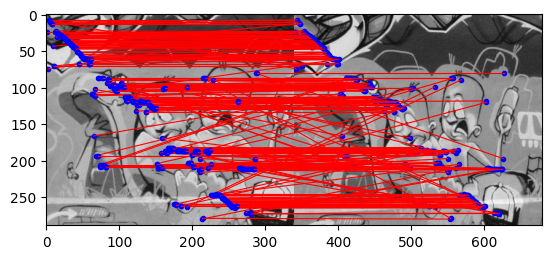

In [266]:
# Read in the images
img_a = cv2.imread("data/graf/graf_a_small.jpg")
img_b = cv2.imread("data/graf/graf_b_small.jpg")

img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)

img_a = img_a.astype(np.float64) / np.max(img_a)
img_b = img_b.astype(np.float64) / np.max(img_b)

indices = find_correspondences(img_a, img_b)
indices_a = filter(lambda x: x[0], indices)
indices_b = filter(lambda x: x[1], indices)
#desc1 = simple_descriptors(img_a, indices_a, indices_b)
display_matches(img_a, indices_a, img_b, indices_b)
#print(desc1)